### Статистические модели прогнозирования.

Визуализировать исходный временной ряд, сделать первичные выводы о присутствии компонент тренда и сезонности в ряде.

1. Отложить последние три года из датасета как тестовую выборку для оценки результатов предсказания.
2. Построить график скользящего среднего, проанализировать результат. Для построения MA использовать метод rolling(), который принимает в качестве параметра размер окна. Использовать среднее как функцию для сглаживания. Подобрать ширину окна.
- Визуализировать исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравнить графики между собой и сделать выводы.


In [ ]:
%pip install statsmodels

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as SGT
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [38]:
df=pd.read_csv('/Users/ulabakulina/Desktop/piton/MATH&ML-13. Временные ряды. Часть II/ghana_gdp.csv', parse_dates=["year"], index_col=["year"])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


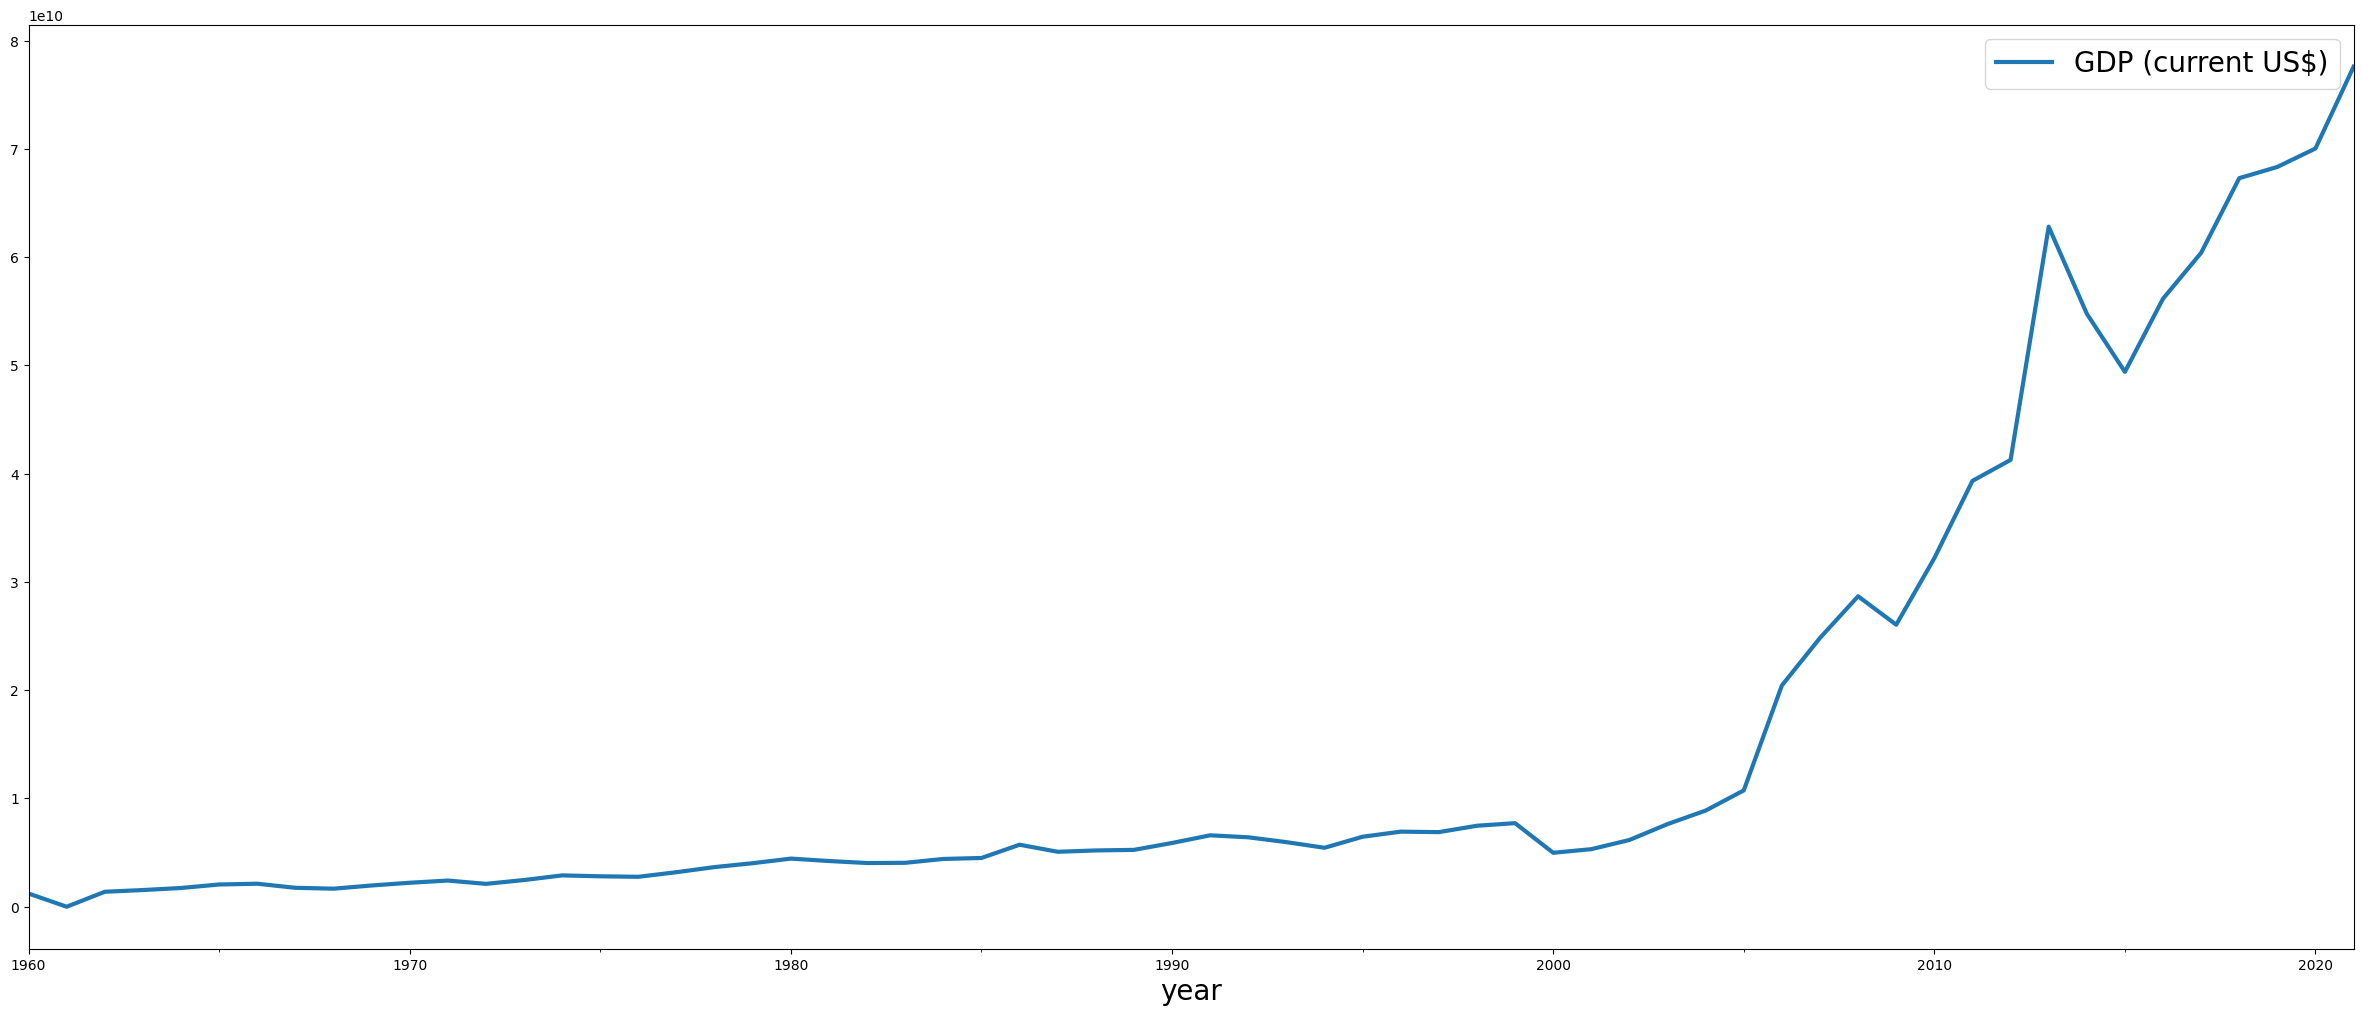

In [39]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

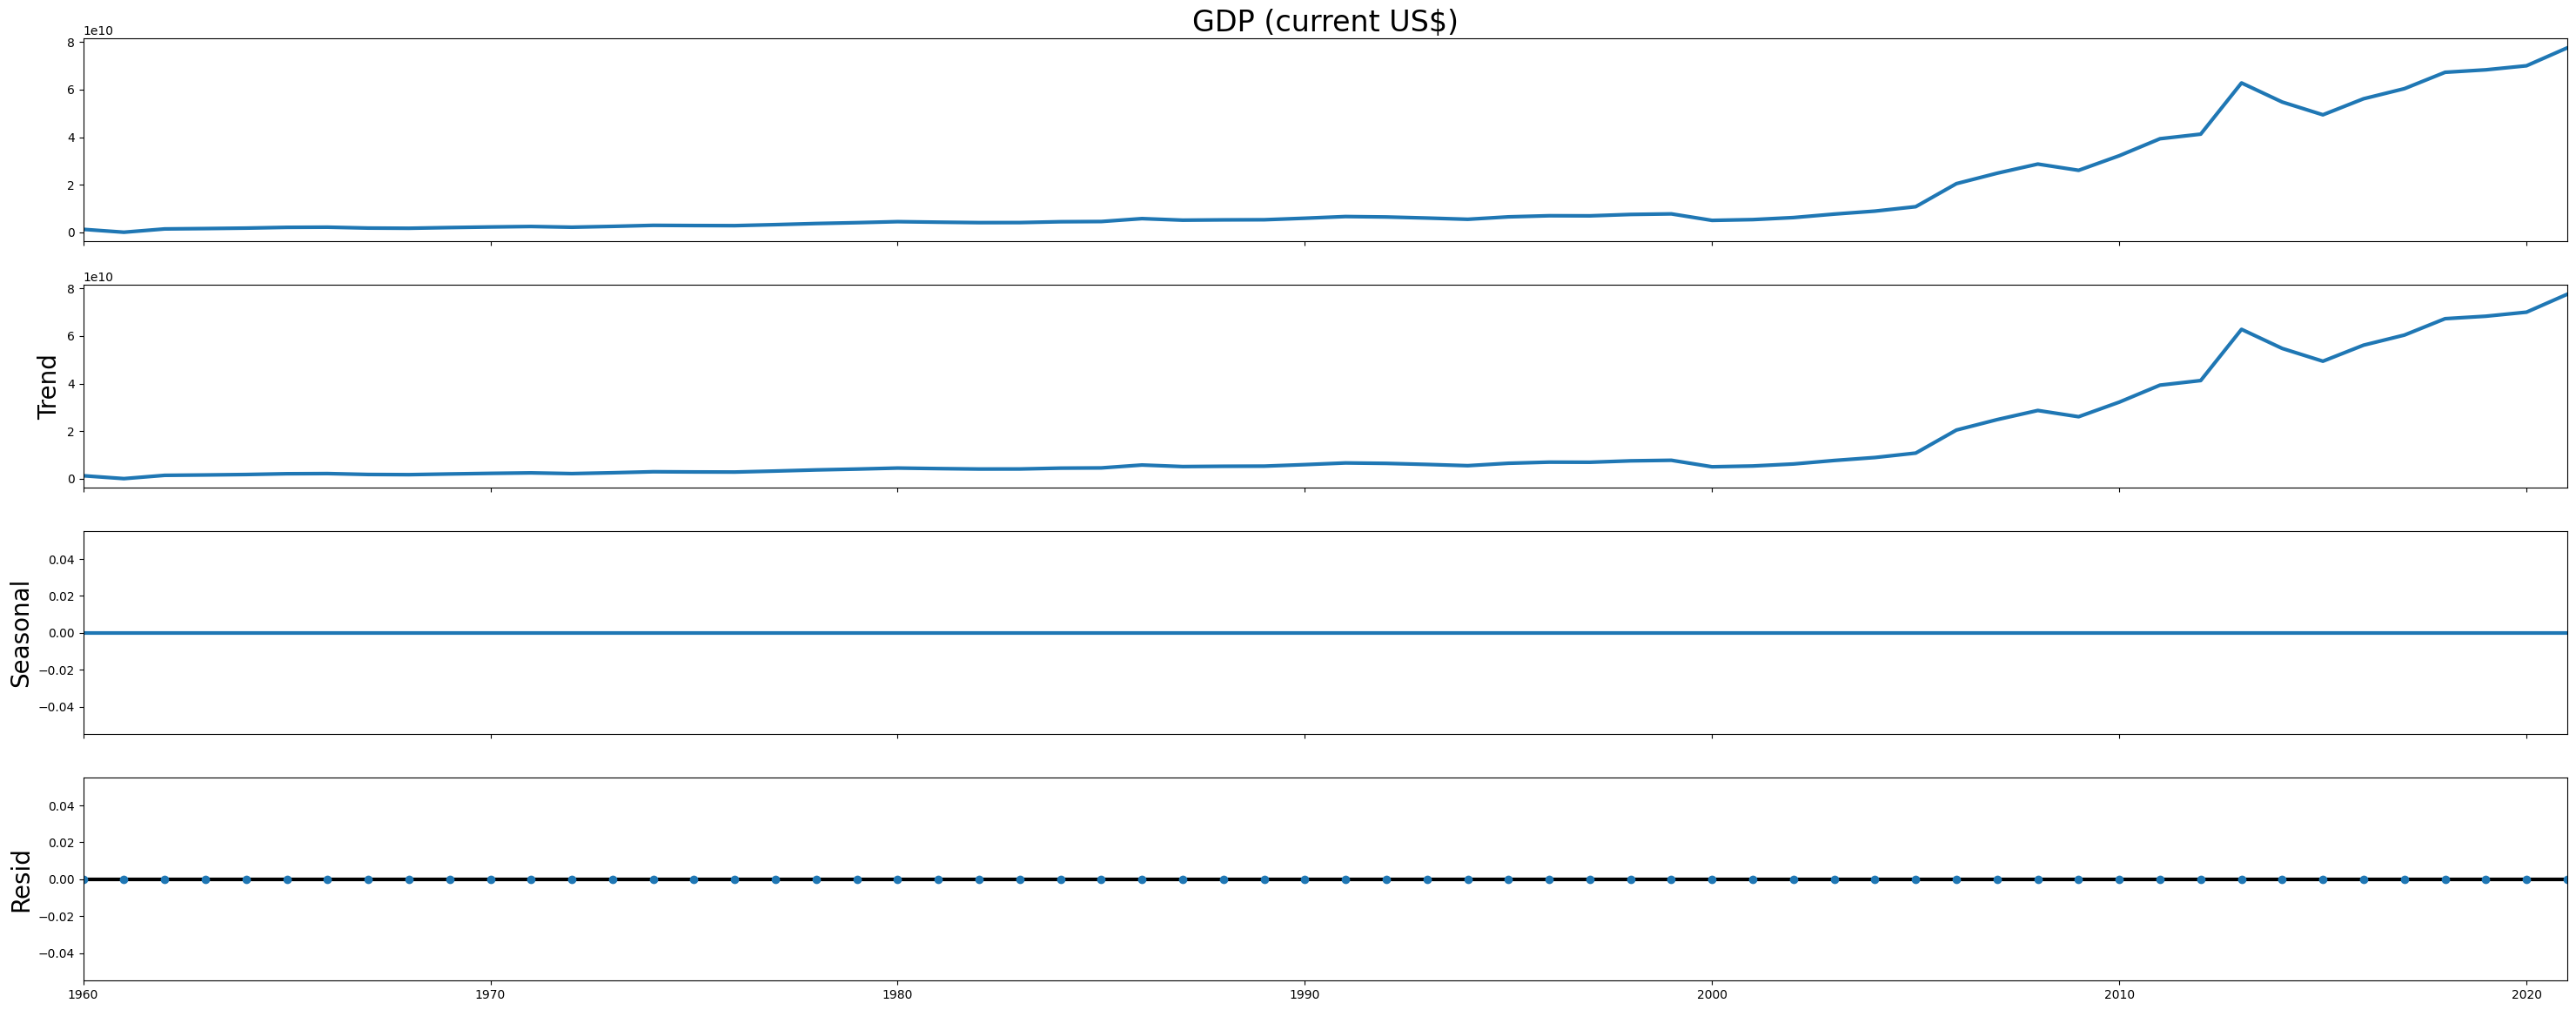

In [40]:
resault=seasonal_decompose(df['GDP (current US$)'])
resault.plot()
plt.show()

На графике видим тренд, который состоит из двух частей, где в Гане ВВП с 1960 года по 2000 медленно увеличивался, а с 2005 года видим быстрый рост. Также видим, что сезонность отсутствует, возможно по причине, что данные предоставлены только за первое число каждого года. Шума в данных нет.

In [41]:
df.index.min()

Timestamp('1960-01-01 00:00:00')

In [42]:
df.index.max()

Timestamp('2021-01-01 00:00:00')

In [43]:
train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape


((59, 1), (3, 1))

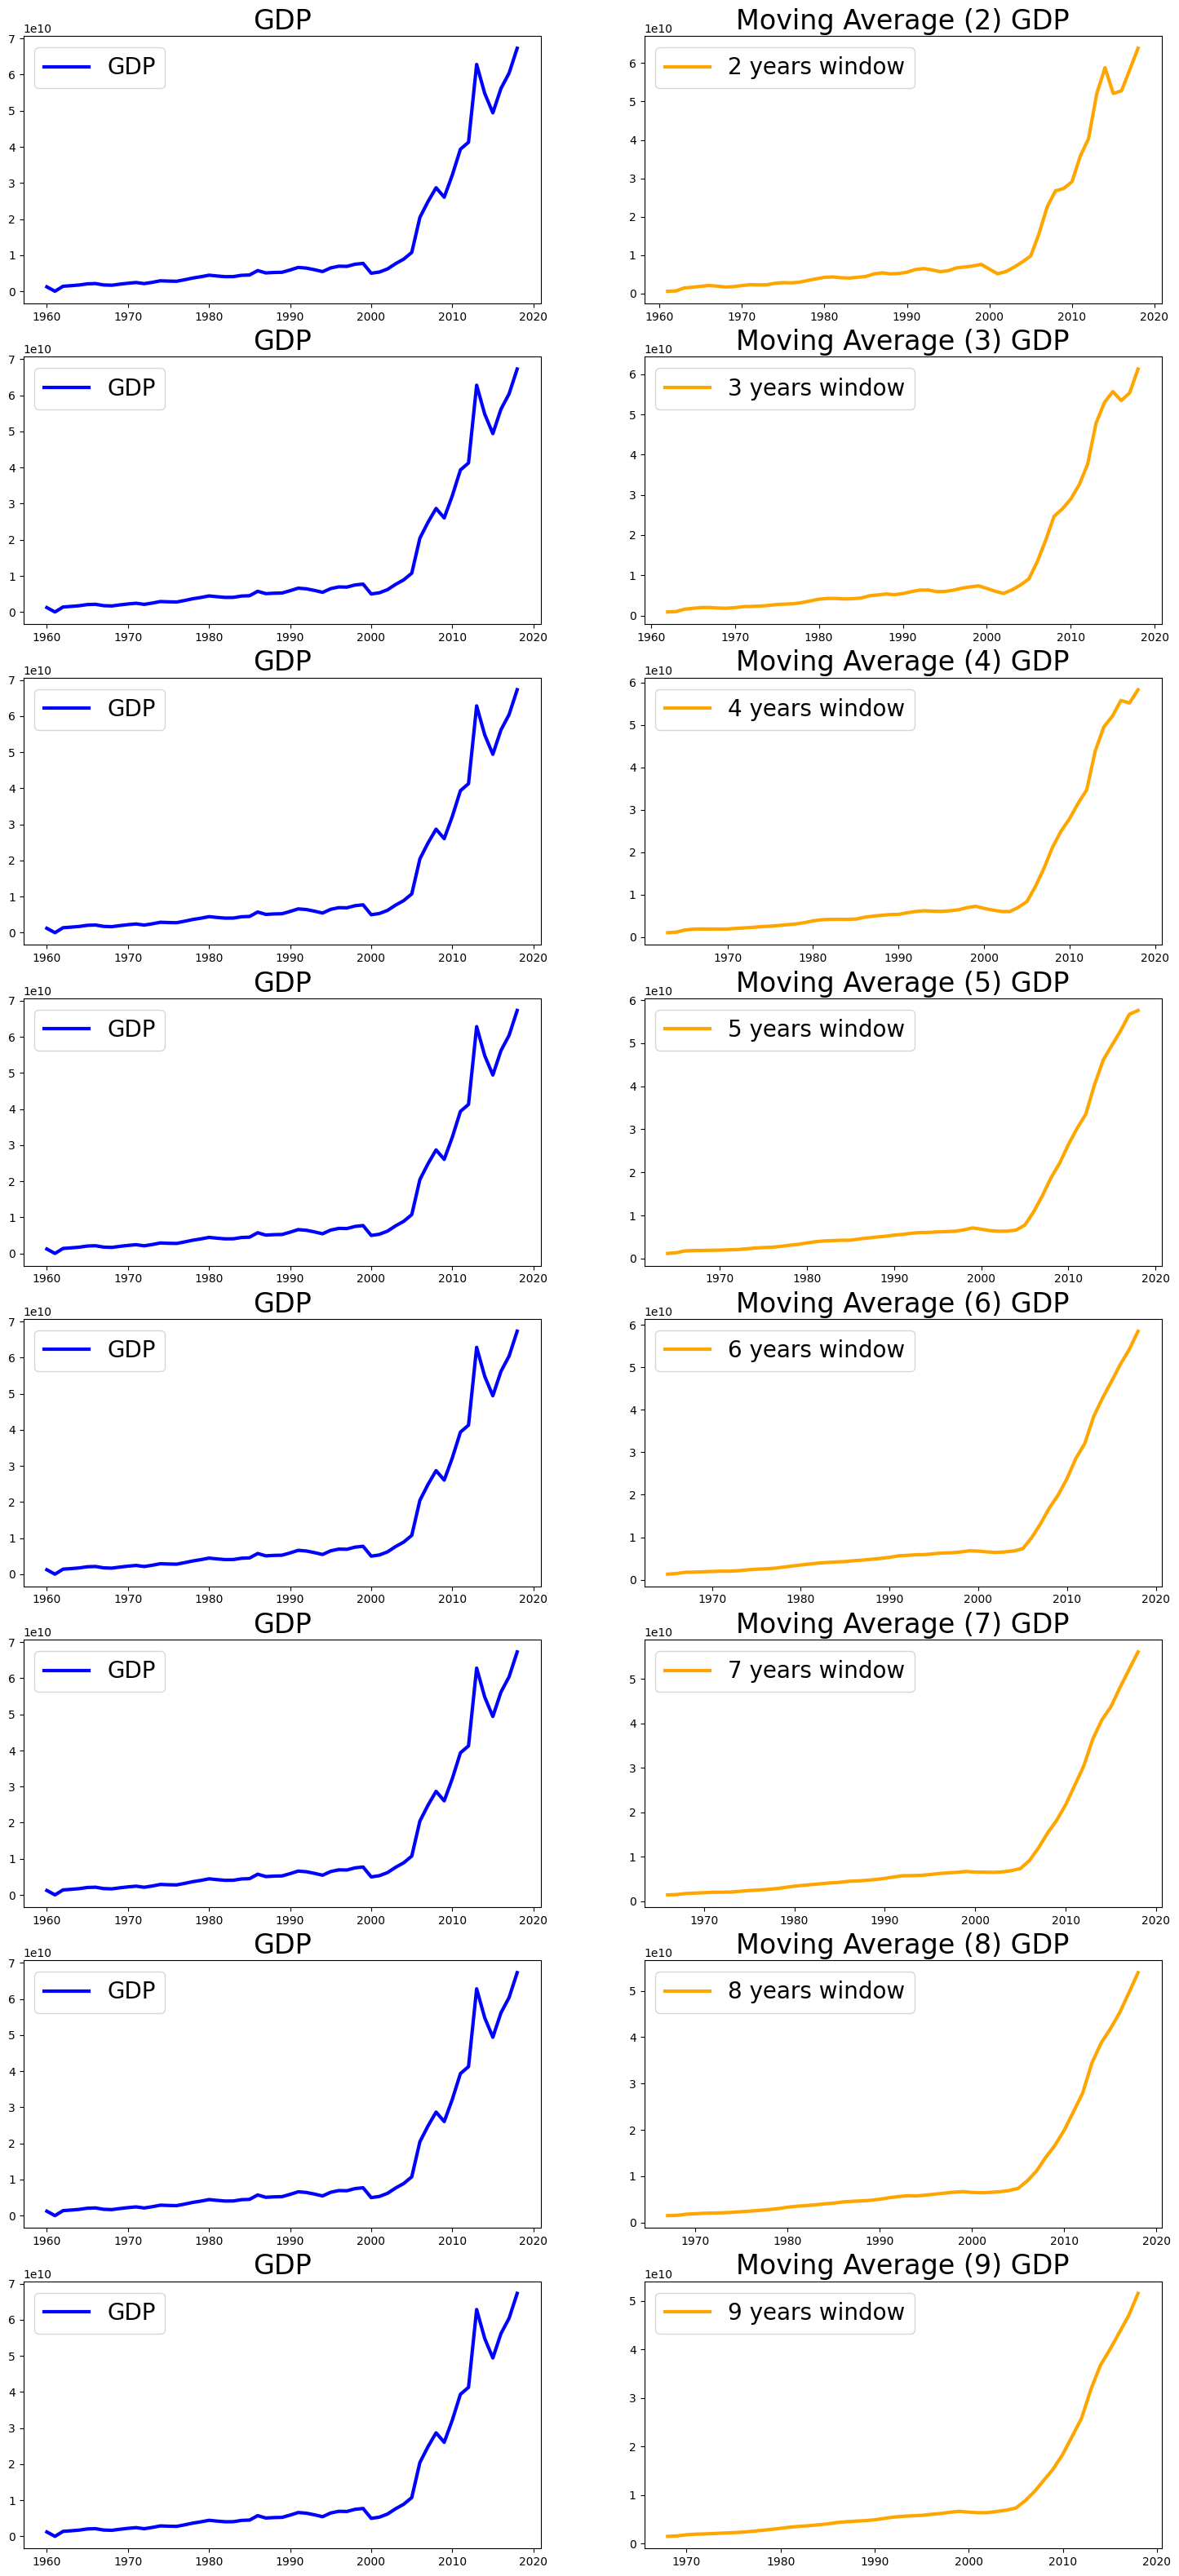

In [44]:
plt.rcParams["figure.figsize"] = 18, 40

windows_list = range(2, 10)
total_windows = len(windows_list)
fig, ax = plt.subplots(total_windows, 2)

i = 0
for window in windows_list:
    ax[i, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
    ax[i, 0].set_title("GDP", size=24)
    ax[i, 0].legend()

    ax[i, 1].plot(
        train_df['GDP (current US$)'].rolling(window=window).mean(),
        color="orange",
        label=f"{window} years window",
    )

    ax[i, 1].set_title(f"Moving Average ({window}) GDP", size=24)
    ax[i, 1].legend()
    i += 1
plt.show()

Начиная с 5 окна скользяшее среднее приводит к потере информации. Колебание тренда теряется после 2005 года. Так как в данных нет выбросов и сезонности, а также мало данных, то скользящее среднее будет показывать неточный прогноз. Для прогноза было выбрано окно равное 2, так как это наилучшее приближение к реальным данным.

С помощью теста Дики-Фуллера оценить стационарность временного ряда и принять решение о выборе модели ARMA/ARIMA.

In [45]:
def stacionarity(data):
    test1 = adfuller(data)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")
stacionarity(train_df['GDP (current US$)'])

adf:  0.6529066974885376
p-value:  0.9888496277665573
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


In [46]:
train_df_dif1=train_df['GDP (current US$)'].diff().dropna()
stacionarity(train_df_dif1)

adf:  -1.670248303832081
p-value:  0.44650293297138743
Critical values:  {'1%': np.float64(-3.568485864), '5%': np.float64(-2.92135992), '10%': np.float64(-2.5986616)}
ряд нестационарен


In [47]:
train_df_dif2=train_df['GDP (current US$)'].diff().diff().dropna()
stacionarity(train_df_dif2)

adf:  -2.6408690561284875
p-value:  0.0848411691783772
Critical values:  {'1%': np.float64(-3.5714715250448363), '5%': np.float64(-2.922629480573571), '10%': np.float64(-2.5993358475635153)}
ряд нестационарен


In [48]:
train_df_dif3=train_df['GDP (current US$)'].diff().diff().diff().dropna()
stacionarity(train_df_dif3)

adf:  -4.7796237848285275
p-value:  5.948327640225032e-05
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд стационарен


Ряд изначально был нестационарный, но с помощью функции diff() сделали его стационарным. Поскольку ряд нестационарен и нет внешних факторов, которые влияют на данные, также отсутствует сезонность, то выбираем модель для прогноза ARIMA. Порядок дифференцирования = 3

<function matplotlib.pyplot.show(close=None, block=None)>

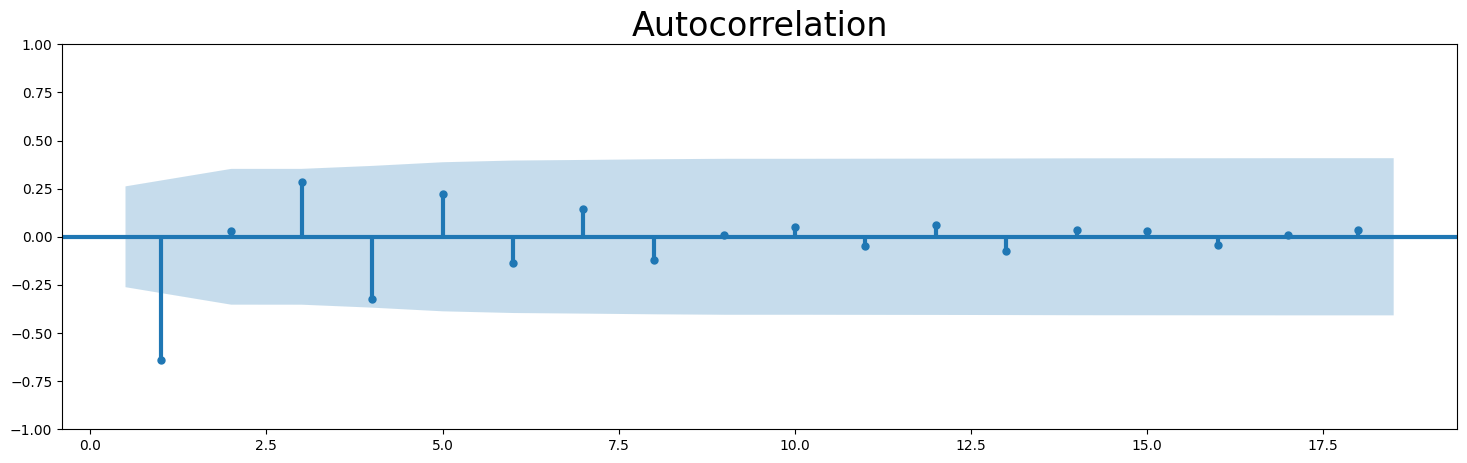

In [49]:
plt.rcParams['figure.figsize']=18,5
SGT.plot_acf(train_df_dif3,zero=False)
plt.show

График автокорреляции показывает максимальное значение при лаге = 1.

<function matplotlib.pyplot.show(close=None, block=None)>

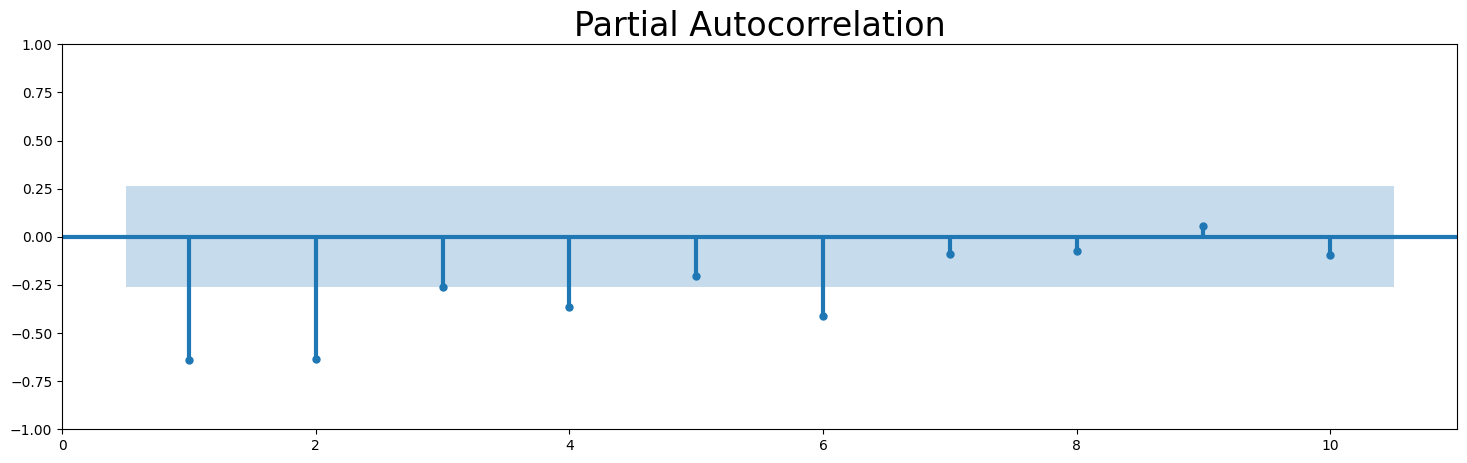

In [50]:
plt.rcParams['figure.figsize']=18,5
SGT.plot_pacf(train_df_dif3,zero=False,lags=10)
plt.show

Данный график показывает, что последний лаг, который отличается от 0 на графике частичной автокорреляции = 6.

In [52]:
p = 6
q = 1
d = 3
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Sun, 07 Sep 2025   AIC                           2629.140
Time:                        10:12:08   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.942      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.659      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.714      0.000      -1.924      -1.373
ar.L5         -1.2768      0.159     -8.021      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.975      0.000      -1.176      -0.595
ma.L1         -0.5920      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.3e+53. Standard errors may be unstable.
"""

- Построть модель ARMA/ARIMA для прогнозирования поведения временного ряда.

- Также построить несколько моделей с параметрами, ближайшими к найденным p и q, и сравнить коэффициент AIC (или подобрать наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
- Построить модель с наилучшими параметрами и выполнить предсказание для отложенной тестовой выборки (последние три года).
- Отобразить результат графически — построить графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
- Сделать выводы по полученным результатам.

In [ ]:
#import pmdarima as pm

#smodel = pm.auto_arima(
    #train_df['GDP (current US$)'].dropna(),
    #start_p=1,
    #d=3,
    #start_q=1,
    #max_p=6,
    #max_q=6,
    #seasonal=False,
    #test="adf",
    #error_action="ignore",
    #trace=True,
#)

#smodel.summary()

Модель предсказания ARIMA, при параметрах модели d=3,p=6,q=1 AIC=2629.140. Модель с помощью библиотеки pmdarima не смогли запустить из-за проблем с зависимостью с библиотекой numpy.

In [53]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

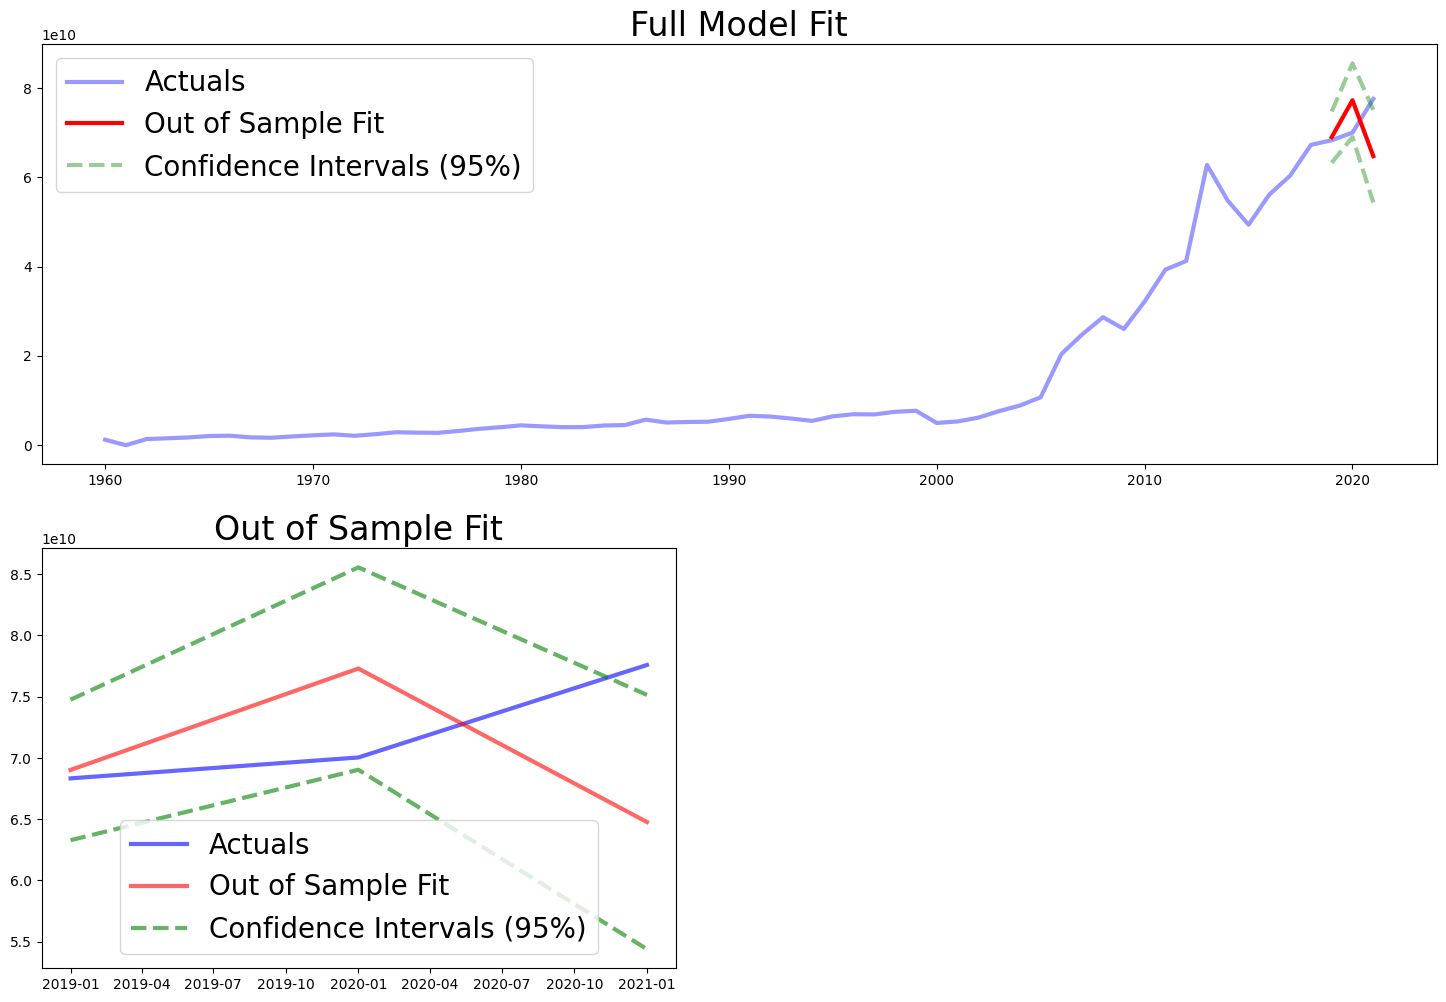

In [54]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()


По итогу видим, что модель не справляется с актуальными даными, поэтому принято решение изменить параметры.

In [55]:
p = 2
q = 1
d = 3
best_arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
best_arima_model_fit = best_arima_model.fit()
best_arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 07 Sep 2025   AIC                           2659.231
Time:                        10:12:25   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.83e+56. Standard errors may be unstable.
"""

In [56]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df['GDP (current US$)']

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

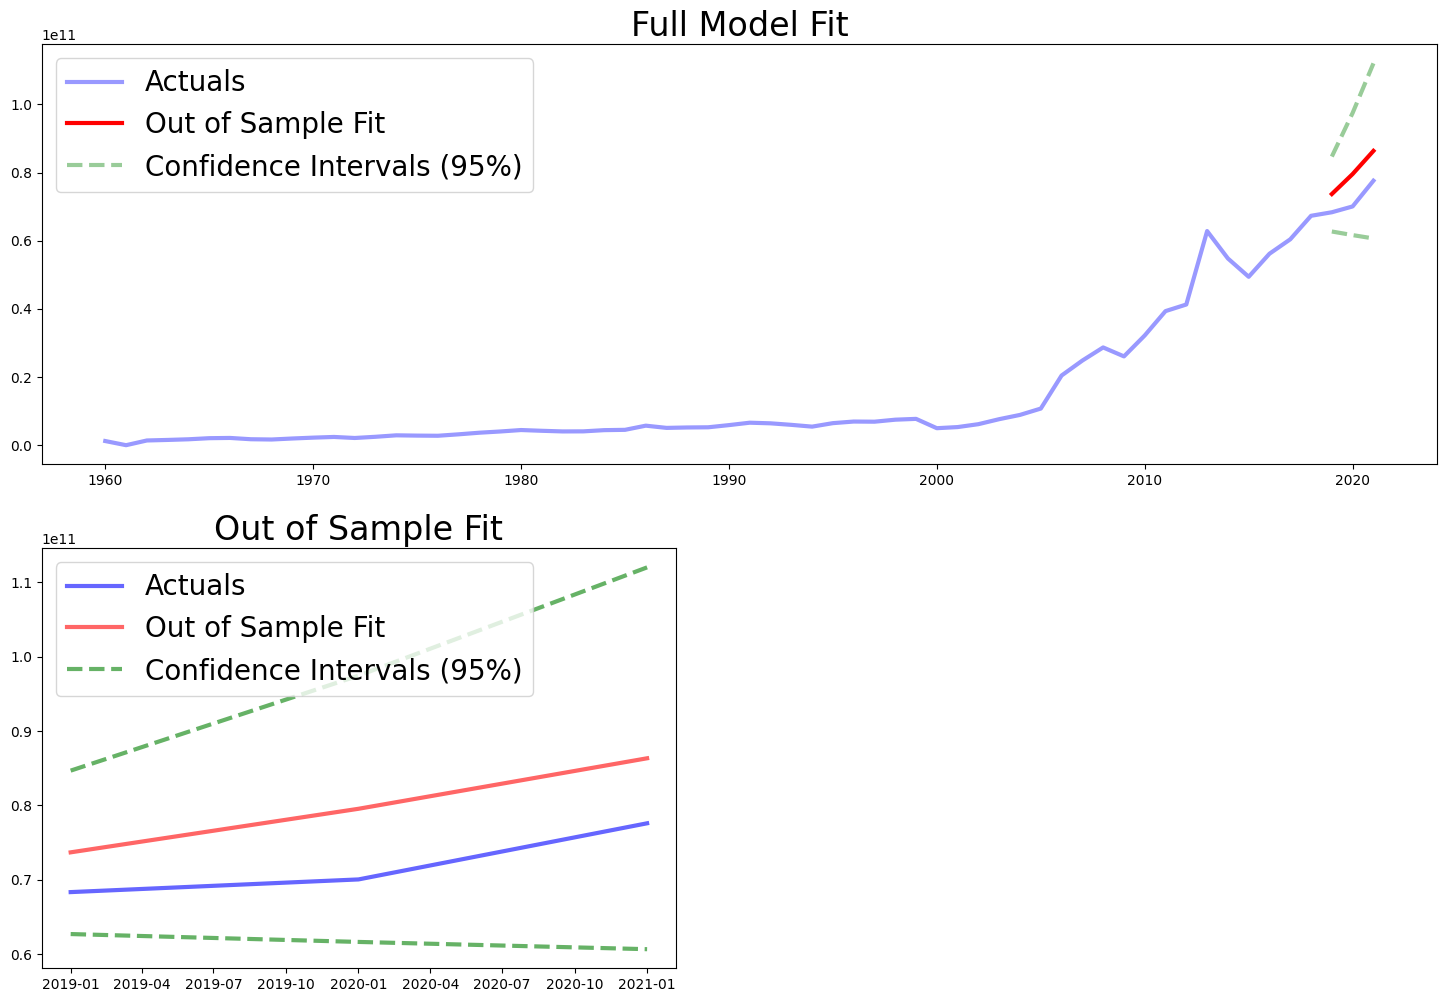

In [57]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

По итогу видим, что модель ARIMA с оптимальными параметрами q=1, p=2, d=3 показала лучшие результаты на тестовых данных по сравнению с моделью ARIMA  c параметрами подобранными из коррелаграммы. AIC = 2659.231.

### Интерполяция и сэмплирование.

1. Проверить данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. 
2. Проверить данные на наличие пропущенных значений (Series.isna().sum()).
3. Обратить внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделать проверку на наличие нулевых значений и в случае нахождения заменить их на NaN. 
4. Для заполнения пропусков выполнить интерполяцию с использованием метода .interpolate().
5. Проверить полученный ряд на стационарность, определить параметры модели (ARIMA/ARMA) и запустить модель.
6. Сделать вывод - изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных.

In [58]:
inter_df = df.asfreq(freq='AS')

/var/folders/4p/61221tbs1lq96mmqjjf1m7m40000gn/T/ipykernel_57096/2177449422.py:1: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  inter_df = df.asfreq(freq='AS')


In [59]:
df.isna().sum()

GDP (current US$)    0
dtype: int64

In [60]:
inter_df['GDP (current US$)'] = inter_df['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)

In [61]:
inter_df['GDP (current US$)'] = inter_df['GDP (current US$)'].interpolate(method='linear')


Было найдено одно пропущенное значение, и мы его заполнили с помощью интерполяции линейной регрессии.

In [62]:
train_df = inter_df.loc[:"2018-01-01"]
test_df = inter_df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

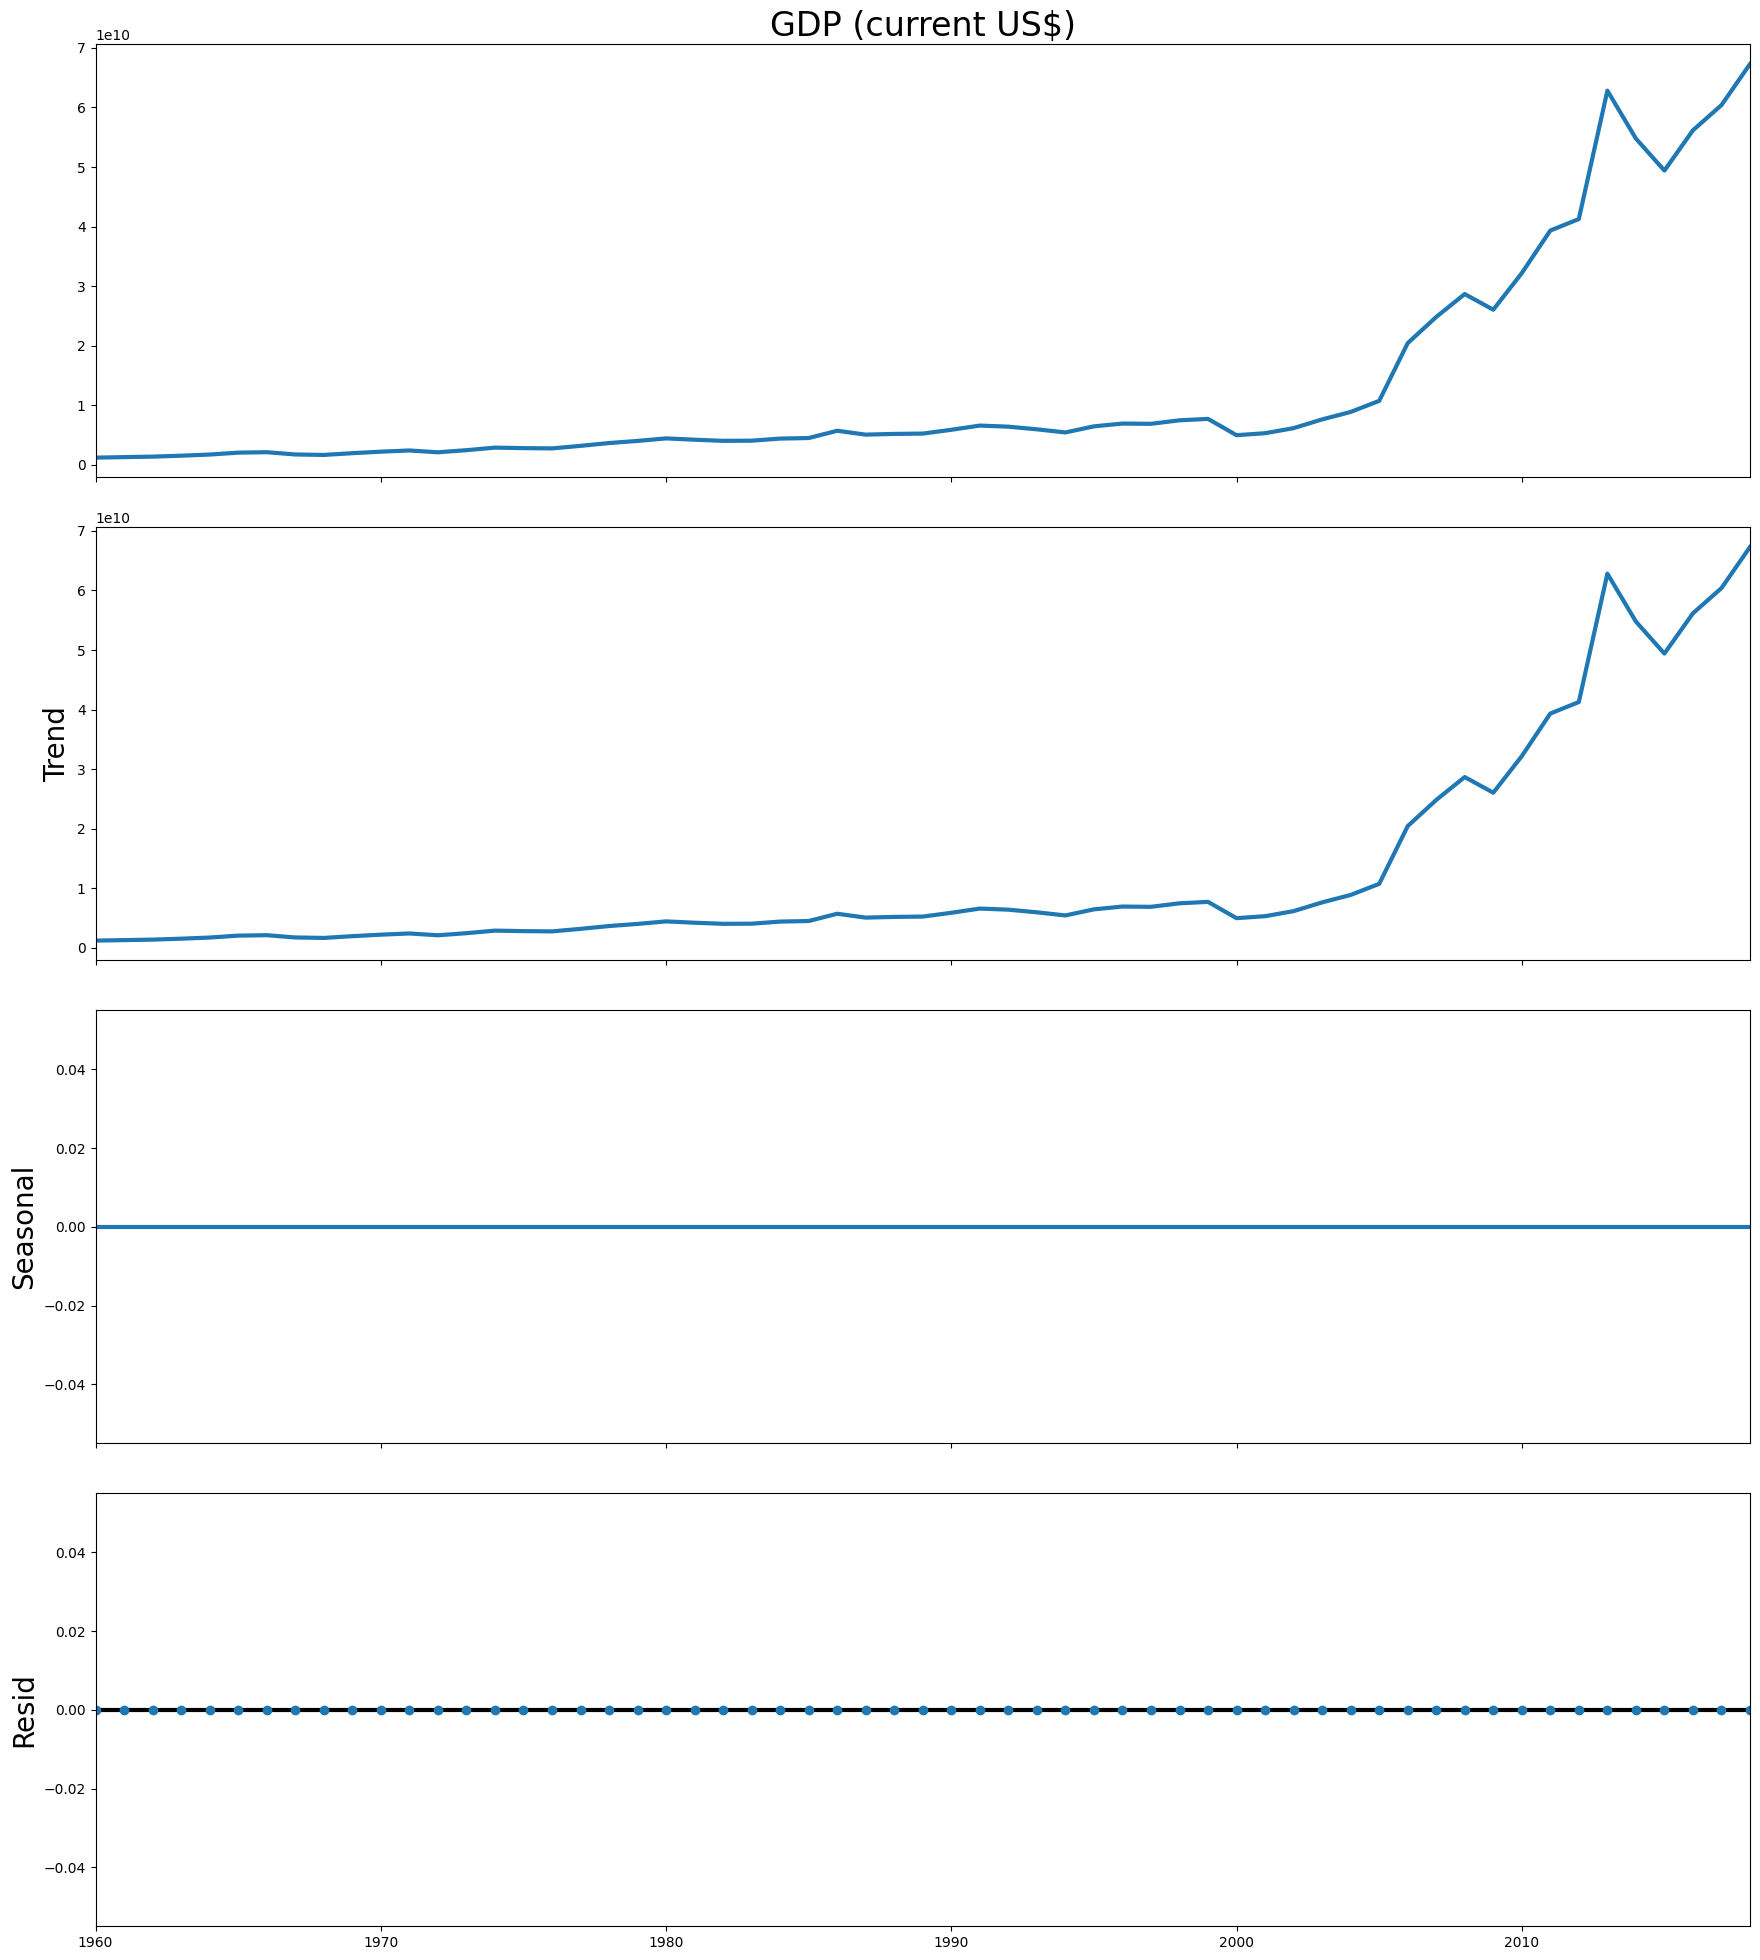

In [63]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

Отрисовали график на котором видим, что исходные данные совпадают с трендом. Сезонность и зашумленность отсутствуют.

In [64]:
stacionarity(train_df['GDP (current US$)'])

adf:  0.8030073326980077
p-value:  0.9916845572455876
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


In [65]:
data_diff1=train_df['GDP (current US$)'].diff().dropna()
stacionarity(data_diff1)

adf:  -1.8255652246435983
p-value:  0.36784515276563506
Critical values:  {'1%': np.float64(-3.568485864), '5%': np.float64(-2.92135992), '10%': np.float64(-2.5986616)}
ряд нестационарен


In [66]:
data_diff2=train_df['GDP (current US$)'].diff().diff().dropna()
stacionarity(data_diff2)

adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': np.float64(-3.5714715250448363), '5%': np.float64(-2.922629480573571), '10%': np.float64(-2.5993358475635153)}
ряд нестационарен


In [67]:
data_diff3=train_df['GDP (current US$)'].diff().diff().diff().dropna()
stacionarity(data_diff3)

adf:  -4.825603687304059
p-value:  4.857318076799117e-05
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд стационарен


Сделала дифференцирование ряда с заполненными пропущенными значениями с помощью метода интерполяции. И по резуальтатам потребовалось три раза продифференцировать свой ряд, чтобы прийти к результату стационарности. А поскольку у нас нету сезонности, то выбираем модель для прогноза ARIMA с порядком дифференцирования d=3.  

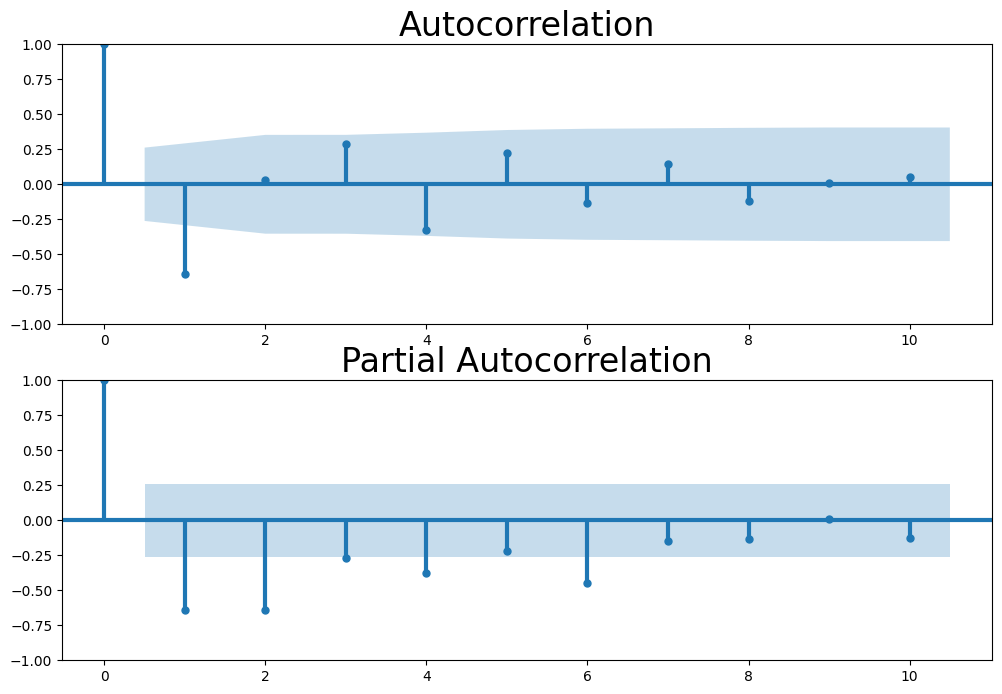

In [68]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=SGT.plot_acf(data_diff3.values.squeeze(),lags=10,ax=ax1)
ax2=fig.add_subplot(212)
fig=SGT.plot_pacf(data_diff3,lags=10,ax=ax2)
plt.show()

График автокорреляции показывает максимальное значение при лаге = 1, поэтому берем q=1. На графике частичной автокорреляции последний лаг отличен от 0 и равен 6, но в предыдущем прогоне модели поняла, что модель лучше работает с более выраженным лагом равным 2. Поэтому берем параметр p=2.

In [69]:
p = 2
q = 1
d = 3
best_arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
best_arima_model_fit = best_arima_model.fit()
best_arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 07 Sep 2025   AIC                           2659.226
Time:                        10:14:32   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.65e+57. Standard errors may be unstable.
"""

In [70]:
pred_df = pd.DataFrame(index=inter_df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = inter_df['GDP (current US$)']

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

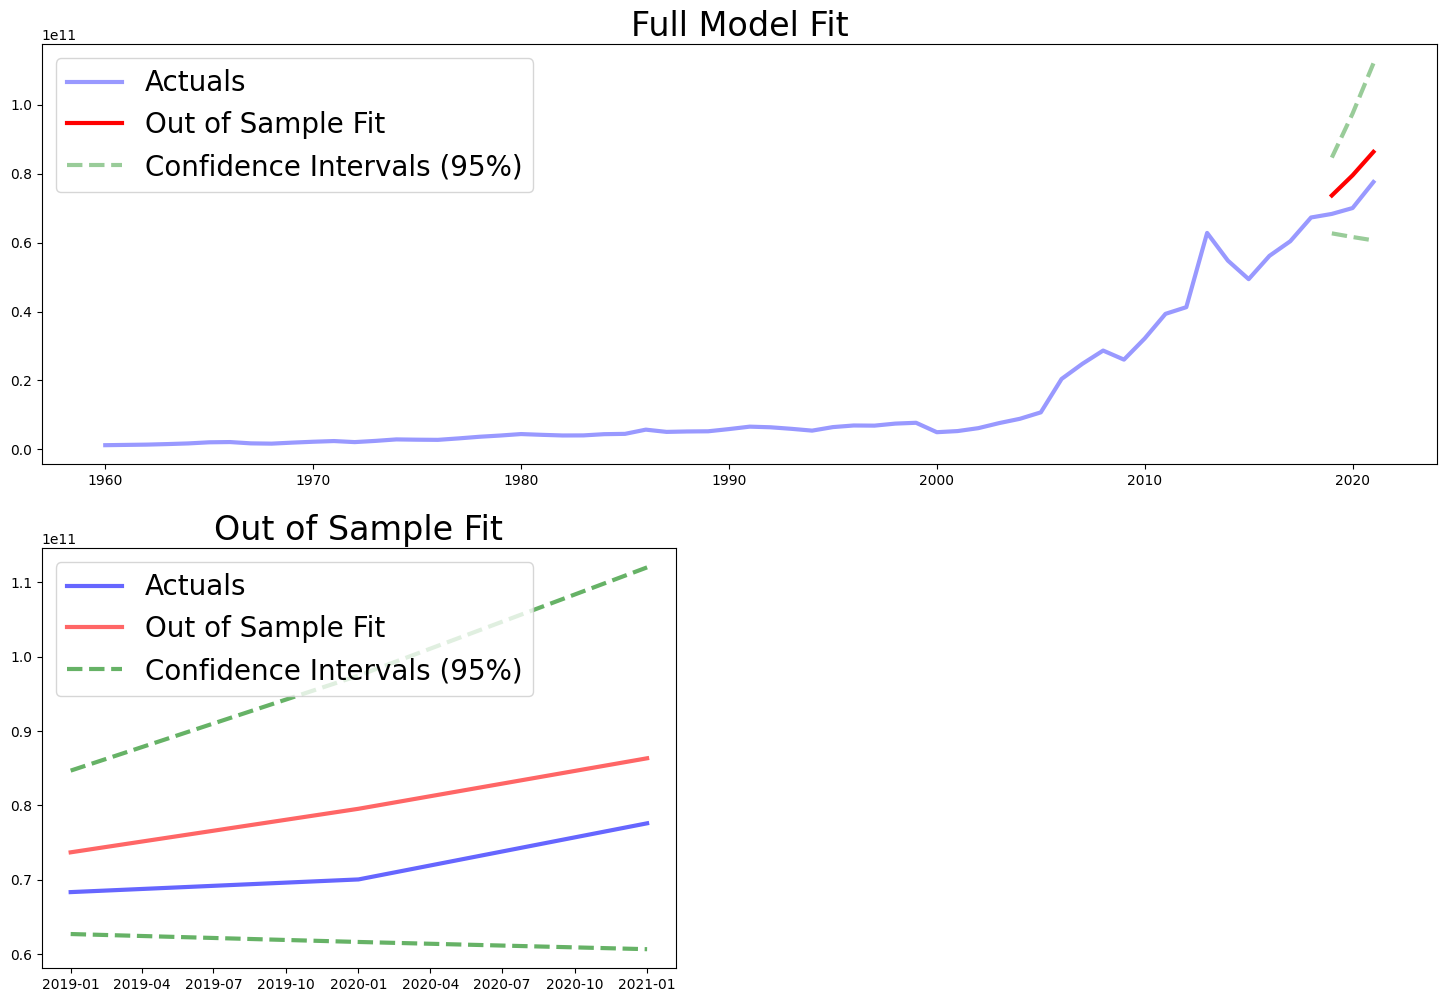

In [71]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

После применения интерполяции не улучшилось значение AIC критерия:

- AIC (для ряда с пропущенным значением) = 2659.231
- AIC (для ряда после интерполяции) = 2659.226

In [73]:
from sklearn.model_selection import train_test_split
data = list(range(10)) ## исходная последовательность данных
print(f'data = {data} \n')
## разбиваем данные при помощи train_ test_split
train, test = train_test_split(data,test_size=0.5, random_state = 42,shuffle=False)
print(f'test = {test}')
print(f'train = {train}')

data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

test = [5, 6, 7, 8, 9]
train = [0, 1, 2, 3, 4]


### Валидация временных рядов. 


1. Разбить временной ряд на три набора (3 train + 3 test). Для этого воспользоваться классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.
2. Вывести размеры полученных подвыборок:
train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

3. Обратить внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. Выведены размеры полученных выборок, проанализировать, какой случай получен по итогу. 



![Снимок экрана 2025-09-07 в 10.48.08.png](<attachment:Снимок экрана 2025-09-07 в 10.48.08.png>)
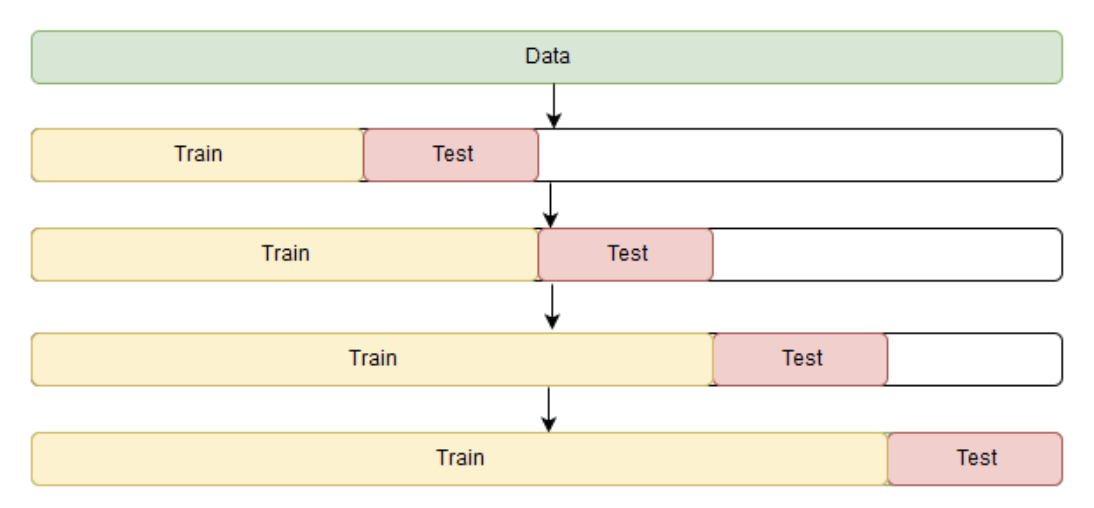

In [74]:
from sklearn.model_selection import TimeSeriesSplit

In [75]:
tscv = TimeSeriesSplit(n_splits=3,test_size=7)

In [76]:
train_test=tscv.split(df['GDP (current US$)'])
for train_index, test_index in train_test:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Вывод: Множественное разбиение. 

### Модели прогнозирования гетероскедастичности. Валидация временных рядов. 

ЗАДАЧИ

1. Посчитать волатильность для временного ряда.
2. Использовать GARCH-модель для предсказания волатильности.
3. Использовать линейную регрессию для получения прогноза.
4. Визуализировать полученное предсказание вместе с фактическим значением.
5. Сравнить результаты и сделайть выводы.
6. Проанализировать, почему результат модели GARCH получился именно таким. 

In [79]:
data=inter_df.copy()
data['vol']=data['GDP (current US$)'].pct_change(1).mul(100).abs()
data.head()

,GDP (current US$),vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


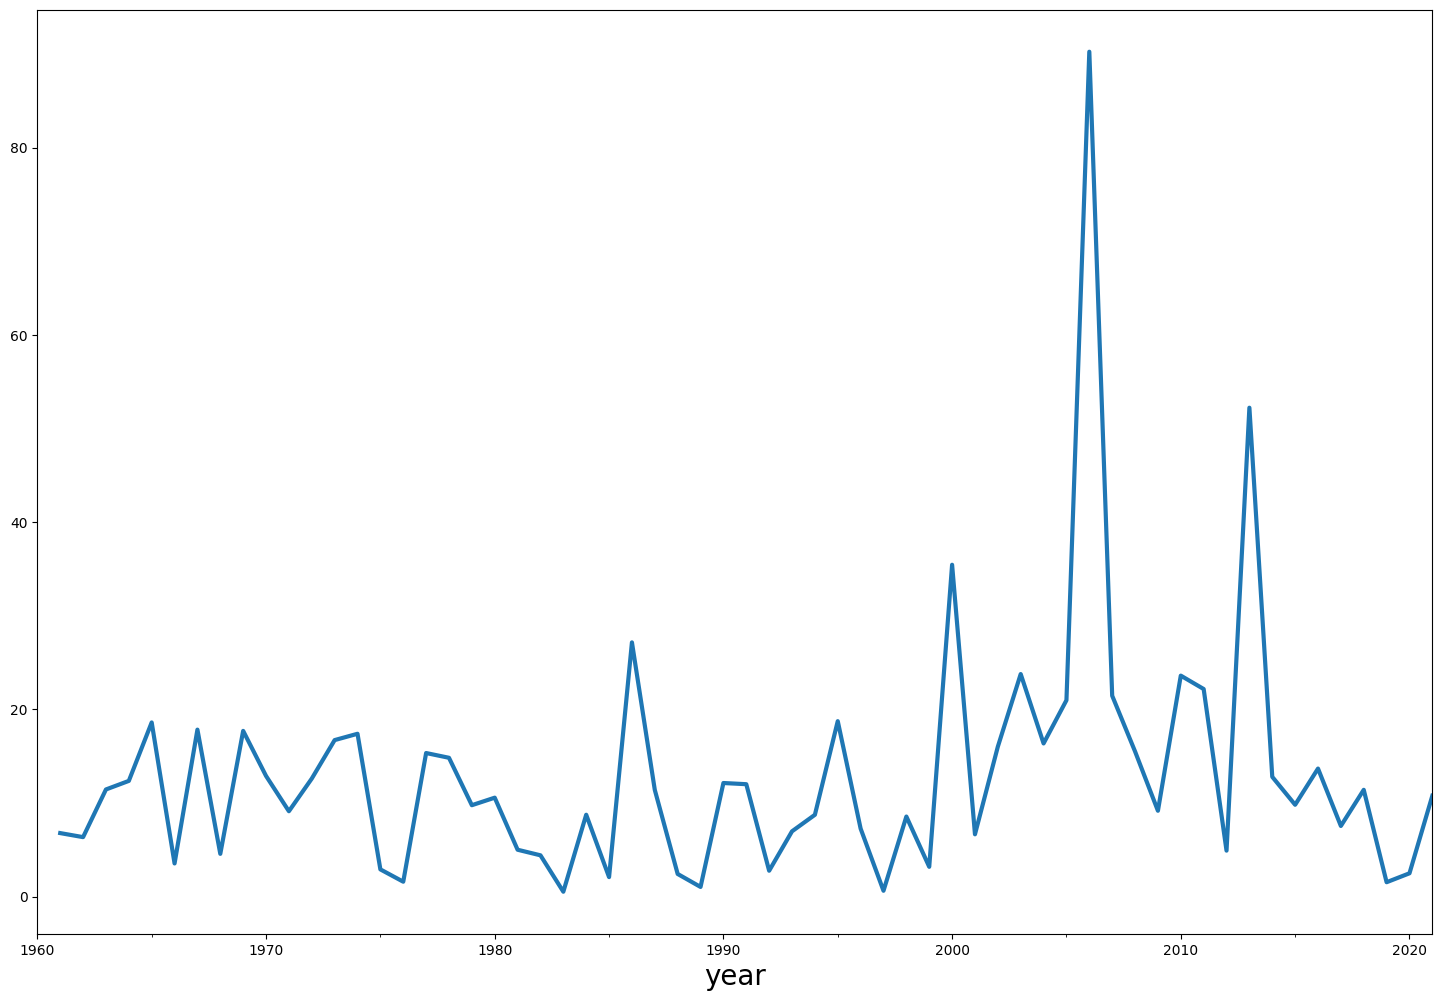

In [80]:
data['vol'].plot()
plt.show()

Исходя из графика видим, что большие колебания наблюдаются в период 2000-2015 годов. Убираем из данных 1960 год, так как волатильность не определена. 

In [82]:
train_df=data.loc['1961-01-01':'2018-01-01']
test_df=data.loc['2019-01-01':]
train_df.shape,test_df.shape

((58, 2), (3, 2))

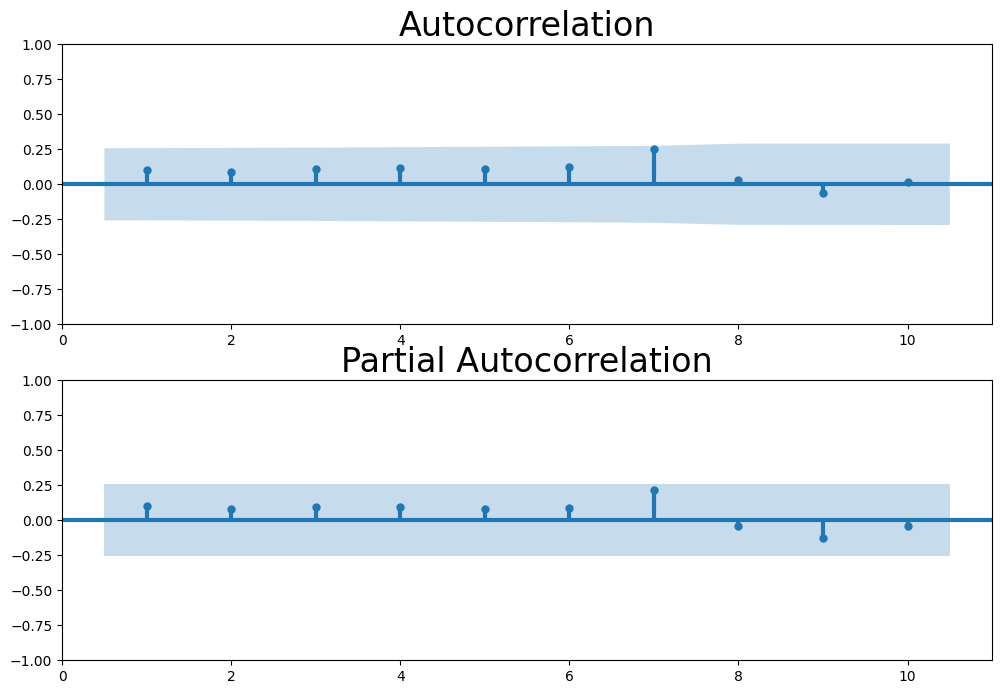

In [84]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=SGT.plot_acf(train_df.vol,lags=10,ax=ax1,zero=False)
ax2=fig.add_subplot(212)
fig=SGT.plot_pacf(train_df.vol,lags=10,ax=ax2,zero=False)
plt.show()

In [85]:
stacionarity(train_df.vol)

adf:  -6.725311059553777
p-value:  3.4014596148856737e-09
Critical values:  {'1%': np.float64(-3.5506699942762414), '5%': np.float64(-2.913766394626147), '10%': np.float64(-2.5946240473991997)}
ряд стационарен


На обоих графиках видны отличающиеся значения при лаге = 7, применим ARIMA. 

In [87]:
p = 1
q = 1
d = 0
best_arima_model = ARIMA(train_df['vol'].dropna(), order=(p, d, q))
best_arima_model_fit = best_arima_model.fit()
best_arima_model_fit.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    vol   No. Observations:                   58
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -233.382
Date:                Sun, 07 Sep 2025   AIC                            474.763
Time:                        11:21:36   BIC                            483.005
Sample:                    01-01-1961   HQIC                           477.974
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4412      4.910      2.737      0.006       3.818      23.065
ar.L1          0.9882      0.560      1.766      0.077      -0.108       2.085
ma.L1         -0.9999     23.495     -0.043      0.966     -47.049      45.049
sigma2       182.1448   4197.274      0.043      0.965   -8044.361    8408.650
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               741.66
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):              12.56   Skew:                             3.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Библиотеке ARIMA не удалось найти оптимальное значение, поэтому делаем предсказание для параметров по умолчанию (p=1,q=1), аналогично сделаем предсказания для параметров из графика (p=7,q=7), будем использовать метрику mae для оценки моделей. 

In [88]:
%pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.5/927.5 kB 1.3 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [89]:
from arch import arch_model

In [106]:
model=arch_model(data['vol'].dropna(),p=1,q=1)
model_fit=model.fit(last_obs=test_df.index[0],update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.1878915626098
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4706.3214191493535
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00242793827007
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978314292277
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233256777
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [107]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Mon, Sep 08 2025   Df Residuals:                       57
Time:                        20:07:43   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.664e-06 [  7.279, 17.359]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.815, 52.155]
alpha[1]   4.6731e-11  9.201e-02  5.079e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.723e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [111]:
predict_df=test_df.copy()
predict_df['prediction']=model_fit.forecast().residual_variance.loc[test_df.index]

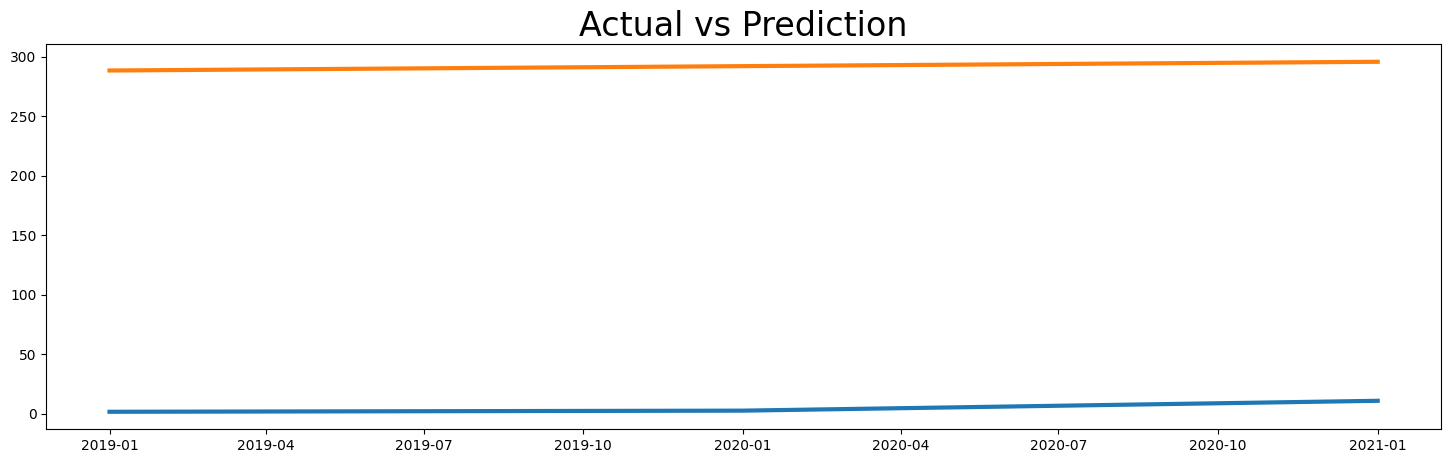

In [115]:
plt.rcParams['figure.figsize']=18,5
plt.plot(predict_df['vol'])
plt.plot(predict_df['prediction'])
plt.title('Actual vs Prediction')
plt.show()

In [116]:
mean_squared_error(predict_df['vol'],predict_df['prediction'])

82530.56514357596

Модель плохо отработала, видна большая разница, mse = 82530.56514357596. 

In [117]:
from sklearn.linear_model import LinearRegression

In [120]:
X_train=pd.DataFrame(range(data['vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test=pd.DataFrame(range(data['vol'].shape[0]))[train_df.shape[0]+1:].fillna(0)
y_train=train_df['vol'].fillna(0)
y_test=test_df['vol'].fillna(0)


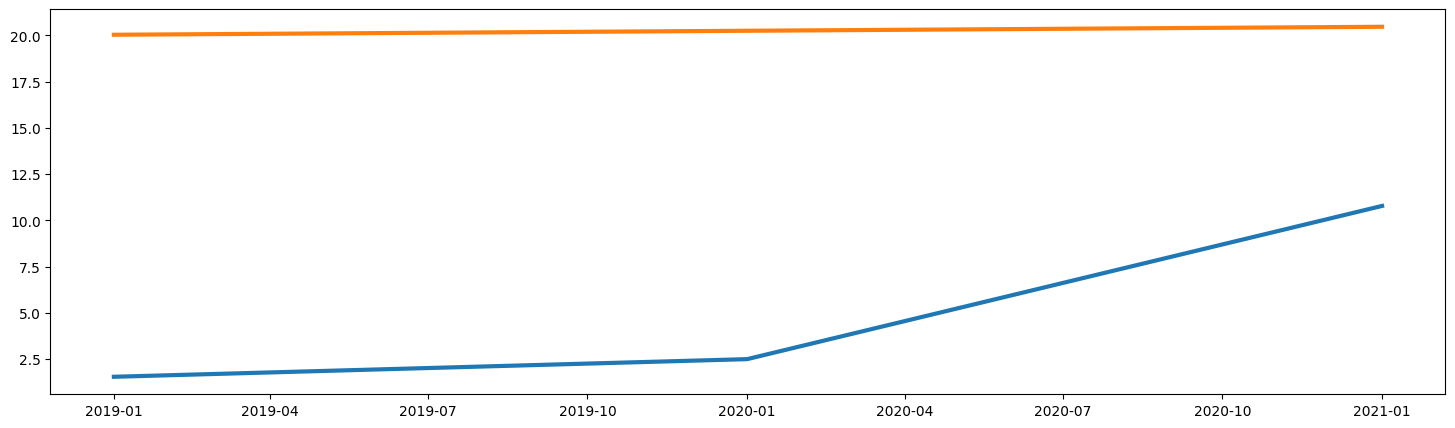

In [121]:
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
predict_lr=model_lr.predict(X_test)
plt.plot(y_test)
plt.plot(pd.Series(predict_lr,index=y_test.index))
plt.show()

In [122]:
mean_squared_error(y_test,predict_lr)

250.343176123252

Модель Линейной регресси отработала лучше, чем предыдущая (GARCH с параметрами p=1, q=1). Проверим еще раз качество модели GARCH с другими параметрами (p=7,q=7).

In [124]:
model=arch_model(data['vol'].dropna(),p=7,q=7)
model_fit=model.fit(last_obs=test_df.index[0],update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38044188848835
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.6175909468402
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.4087174093118
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10034369910417
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.0122611768444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00770181698863
            Iterations: 27
            Function evaluations: 471
            Gradient evaluations: 27


In [126]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.015
Method:            Maximum Likelihood   BIC:                           492.982
                                        No. Observations:                   58
Date:                Mon, Sep 08 2025   Df Residuals:                       57
Time:                        20:34:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8696      1.609      7.377  1.620e-13 [  8.716, 15.023]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.0501     44.821      0.983      0.326    [-43.798,1.319e+02]
alpha[1]   7.1268e-10  8.386e-02  8.498e-09      1.000      [ -0.164,  0.164]
alpha[2]   1.7098e-09  2.388e-02  7.159e-08      1.000 [-4.681e-02,4.681e-02]
alpha[3]   8.2320e-09  7.195e-02  1.144e-07      1.000      [ -0.141,  0.141]
alpha[4]   3.6469e-03  1.592e-02      0.229      0.819 [-2.756e-02,3.485e-02]
alpha[5]   4.0566e-09  1.349e-02  3.008e-07      1.000 [-2.644e-02,2.644e-02]
alpha[6]       0.7309      0.949      0.770      0.441      [ -1.129,  2.591]
alpha[7]       0.1032      0.692      0.149      0.881      [ -1.252,  1.459]
beta[1]    1.2410e-08      0.535  2.320e-08      1.000      [ -1.048,  1.048]
beta[2]    7.9354e-09  6.711e-02  1.183e-07      1.000      [ -0.132,  0.132]
beta[3]    7.4489e-09  3.010e-02  2.475e-07      1.000 [-5.899e-02,5.899e-02]
beta[4]    6.5960e-09  9.653e-02  6.833e-08      1.000      [ -0.189,  0.189]
beta[5]    4.1818e-07  5.358e-02  7.805e-06      1.000      [ -0.105,  0.105]
beta[6]    7.9227e-09  3.110e-02  2.548e-07      1.000 [-6.095e-02,6.095e-02]
beta[7]    6.3213e-09      1.235  5.117e-09      1.000      [ -2.421,  2.421]
=============================================================================

Covariance estimator: robust
"""

In [127]:
predict_df=test_df.copy()
predict_df['prediction']=model_fit.forecast().residual_variance.loc[test_df.index]

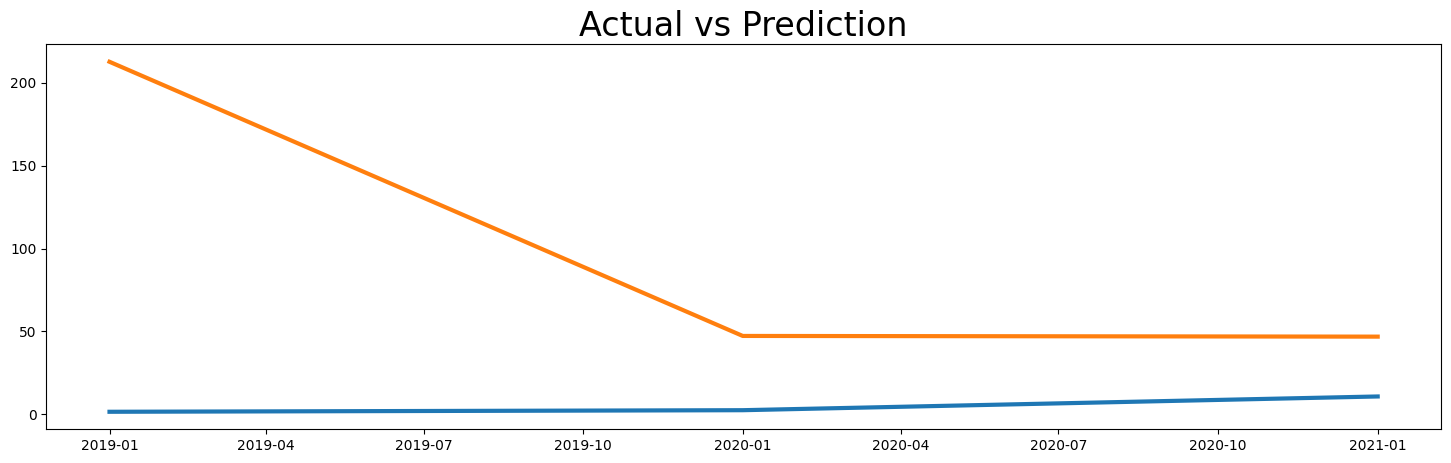

In [128]:
plt.rcParams['figure.figsize']=18,5
plt.plot(predict_df['vol'])
plt.plot(predict_df['prediction'])
plt.title('Actual vs Prediction')
plt.show()

In [129]:
mean_squared_error(predict_df['vol'],predict_df['prediction'])

15967.87077740377

По результатам модели GARCH c параметрами p=7, q=7, видим, что модель отработала лучше, mse=15967.87. Но все равно модель плохо предсказвывает дисперсию, возможно это связано с недостаточным количеством данных. Модель Линейной регрессии ближе к реальным данным, чем модель GARCH. mse=250, но использовать ее вряд ли стоит, поскольку она не учитывает разброс в данных. 

In [130]:
%pip install prophet

207604.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [prophet]m2/4 [cmdstanpy]
Note: you may need to restart the kernel to use updated packages.


In [132]:
import pandas as pd

from prophet import Prophet

df = pd.read_csv('/Users/ulabakulina/Desktop/piton/MATH&ML-13. Временные ряды. Часть II/url.csv')

df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [133]:
model=Prophet()
model.fit(df)

20:51:48 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
df_make=model.make_future_dataframe(periods=365)
df_make.head()


,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3,2007-12-13
4,2007-12-14


In [136]:
df_url=model.predict(df_make)
df_url[['ds','yhat','yhat_lower','yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2007-12-10,8.837861,8.235677,9.446119
1,2007-12-11,8.586432,7.956170,9.212176
2,2007-12-12,8.382337,7.773232,8.989835
3,2007-12-13,8.360277,7.720195,8.963783
4,2007-12-14,8.348334,7.719489,8.956706
...,...,...,...,...
3265,2017-01-15,8.204239,7.458745,8.908777
3266,2017-01-16,8.529231,7.810889,9.314278
3267,2017-01-17,8.316611,7.574070,9.036970
3268,2017-01-18,8.149244,7.445864,8.914082


In [137]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


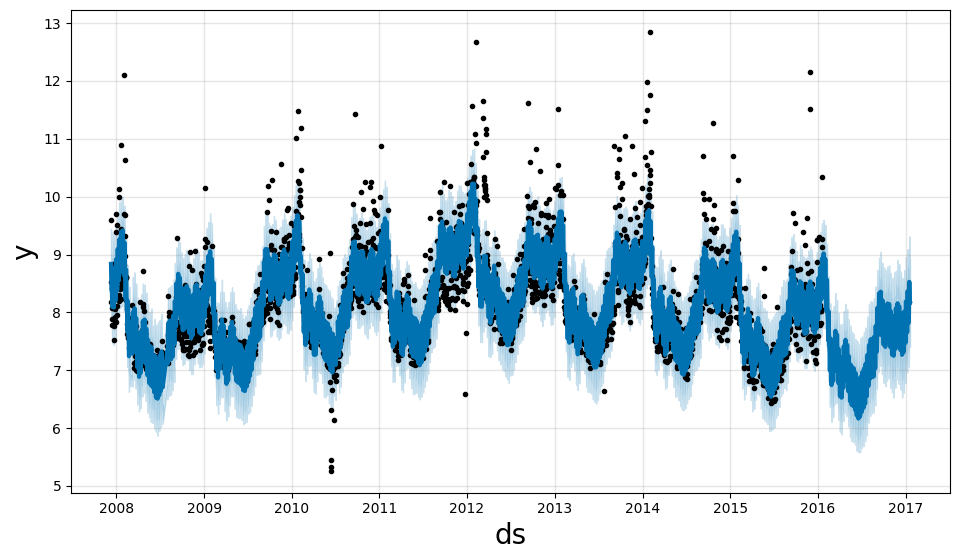

In [138]:
fig = model.plot(df_url)

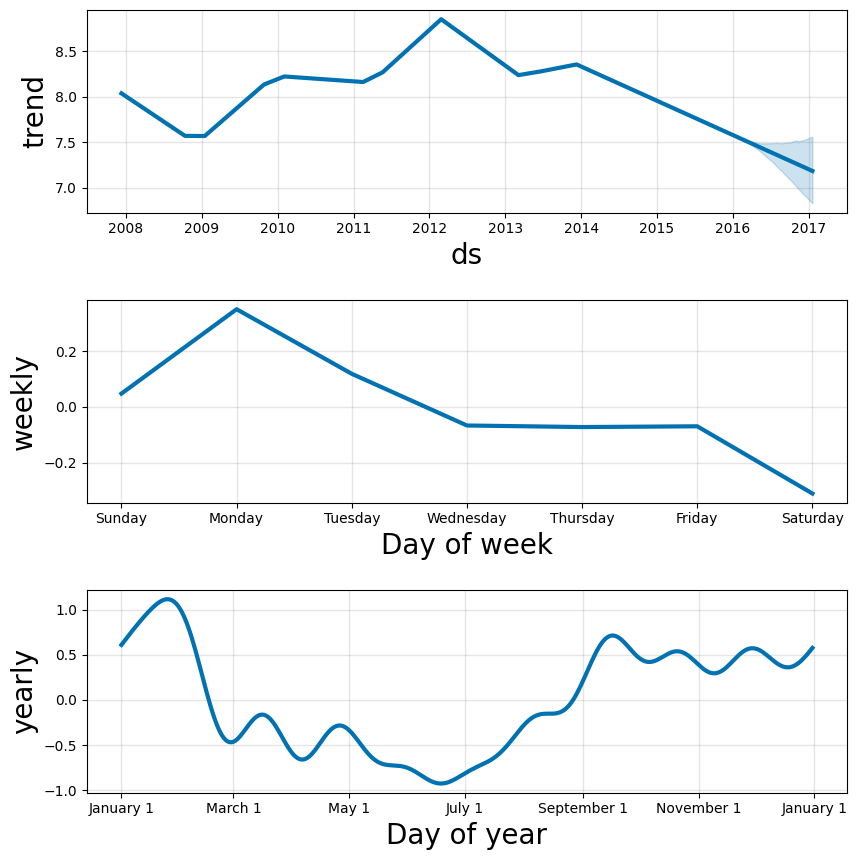

In [139]:
fig = model.plot_components(df_url)